In [44]:
import time, os, sys, pickle, h5py, importlib, gc, copy, re, itertools, json, logging
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'
from tqdm.auto import tqdm, trange
from pathlib import Path
from util import config_logger
from util import openH5File, encode4h5, parse_suffix, config_logger


import numpy as np, pandas as pd, scipy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score

from umap import UMAP
import anndata as ad

import scanpy as sc

import torch
torch.set_num_threads(16)
from model import SpiceMix
from helper import evaluate_embedding_maynard2021 # This function is for the optional on-the-fly evaluation. This is not required for SpiceMix.
fn_eval = evaluate_embedding_maynard2021

from matplotlib import pyplot as plt
from load_data import load_expression, load_edges, load_genelist

import seaborn as sns
sns.set_style("white")
%matplotlib inline
%config InlineBackend.figure_format='retina'

logger = config_logger(logging.getLogger(__name__))

In [45]:
def center_scale(arr):
    return (arr - arr.mean(axis=0)) / arr.std(axis=0)

## Read in murine data

In [46]:
df = pd.read_csv('../../../st_projects/spatial_clust/data/codex_murine/features_and_metadataV2.csv', index_col = 0)

In [48]:
features_names = [
        'CD45',
        'Ly6C',
        'TCR',
        'Ly6G',
        'CD19',
        'CD169',
        'CD106',
        'CD3',
        'CD1632',
        'CD8a',
        'CD90',
        'F480',
        'CD11c',
        'Ter119',
        'CD11b',
        'IgD',
        'CD27',
        'CD5',
        'CD79b',
        'CD71',
        'CD31',
        'CD4',
        'IgM',
        'B220',
        'ERTR7',
        'MHCII',
        'CD35',
        'CD2135',
        'CD44',
        'nucl',
        'NKp46'
    ]
features = df[features_names].to_numpy()
#normalized_df=(df-df.min())/(df.max()-df.min())

features =(features-features.min(axis = 0))/(features.max(axis = 0)-features.min(axis = 0))

# expr_processed = expression / expression.sum(1, keepdims=True) * 1e4
# expr_processed = np.log1p(expr_processed)

In [50]:
save_path = "../data/codex_murine/files"
np.savetxt(os.path.join(save_path, "expression_0_minmax.txt"), features ) 
locations = df[['centroid_x', 'centroid_y']].to_numpy()
adata = ad.AnnData(features, dtype=np.float32)
adata.obsm["spatial"] = locations
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=None, use_rep='spatial')

In [55]:
adata

AnnData object with n_obs × n_vars = 53500 × 31
    uns: 'neighbors'
    obsm: 'spatial'
    obsp: 'distances', 'connectivities'

In [56]:
rows, cols = adata.obsp['connectivities'].nonzero()
edges = np.array([rows, cols]).T

In [60]:
#np.savetxt(os.path.join(save_path, "neighborhood_0.txt"), edges) 
file = open(os.path.join(save_path, "neighborhood_0.txt"),'w')
for i in range(rows.shape[0]):
    file.write(str(rows[i])+" "+str(cols[i])+"\n")
file.close()

In [61]:
file = open(os.path.join(save_path, "genes_0_minmax.txt"),'w')
for item in features_names:
    file.write(item+"\n")
file.close()

In [63]:
file = open(os.path.join(save_path, "celltypes_0.txt"),'w')
for i in range(df.shape[0]):
    file.write(df['cluster.termV2'][i] + "\n")
file.close()

## Run SpiceMix

In [64]:
# -- specify device
context = dict(device='cpu', dtype=torch.float64)
# context = dict(device='cpu', dtype=torch.float64)
context_Y = context
# -- specify dataset
path2dataset = Path('../data/codex_murine/')
repli_list = ['0']

In [65]:
from model import SpiceMix
from helper import evaluate_embedding_maynard2021 # This function is for the optional on-the-fly evaluation. This is not required for SpiceMix.
fn_eval = evaluate_embedding_maynard2021

np.random.seed(0)

K, num_pcs, n_neighbors, res_lo, res_hi = 30, 20, 15, .5, 2.

path2result = path2dataset / 'results' / 'SpiceMix.h5'
os.makedirs(path2result.parent, exist_ok=True)
if os.path.exists(path2result):
    os.remove(path2result)
    
obj = SpiceMix(
    K=K,
    lambda_Sigma_x_inv=1e-6, power_Sigma_x_inv=2,
    repli_list=repli_list,
    context=context,
    context_Y=context,
    path2result=path2result,
)

obj.load_dataset(path2dataset, expression_suffix="minmax")


2023-05-19 01:58:37:INFO:result file = ../data/codex_murine/results/SpiceMix.h5
2023-05-19 01:58:38:INFO:Loaded 53500 cells and 31 genes from ../data/codex_murine/files/expression_0_minmax.txt
2023-05-19 01:58:38:INFO:Loaded 31 genes from ../data/codex_murine/files/genes_0_minmax.txt
2023-05-19 01:58:41:WARNING:Detected 407590 duplicate edge(s) from 815180 loaded edges. Duplicate edges are discarded.
2023-05-19 01:58:41:INFO:Loaded 407590 edges from ../data/codex_murine/files/neighborhood_0.txt


In [ ]:
obj.meta['cell type'] = pd.Categorical(obj.meta['cell type'])
obj.initialize(
    method='louvain', kwargs=dict(num_pcs=num_pcs, n_neighbors=n_neighbors, resolution_boundaries=(res_lo, res_hi), num_rs = 2),
)

In [ ]:
for iiter in range(1, 200):
    logger.info(f'Iteration {iiter}')
    obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)

In [37]:
latent_states = [X.cpu().numpy() for X in obj.Xs]
latent_state_cat = np.concatenate(latent_states, axis=0)

/home/sheng/miniconda3/envs/SpiceMix/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


<AxesSubplot:title={'center':'annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

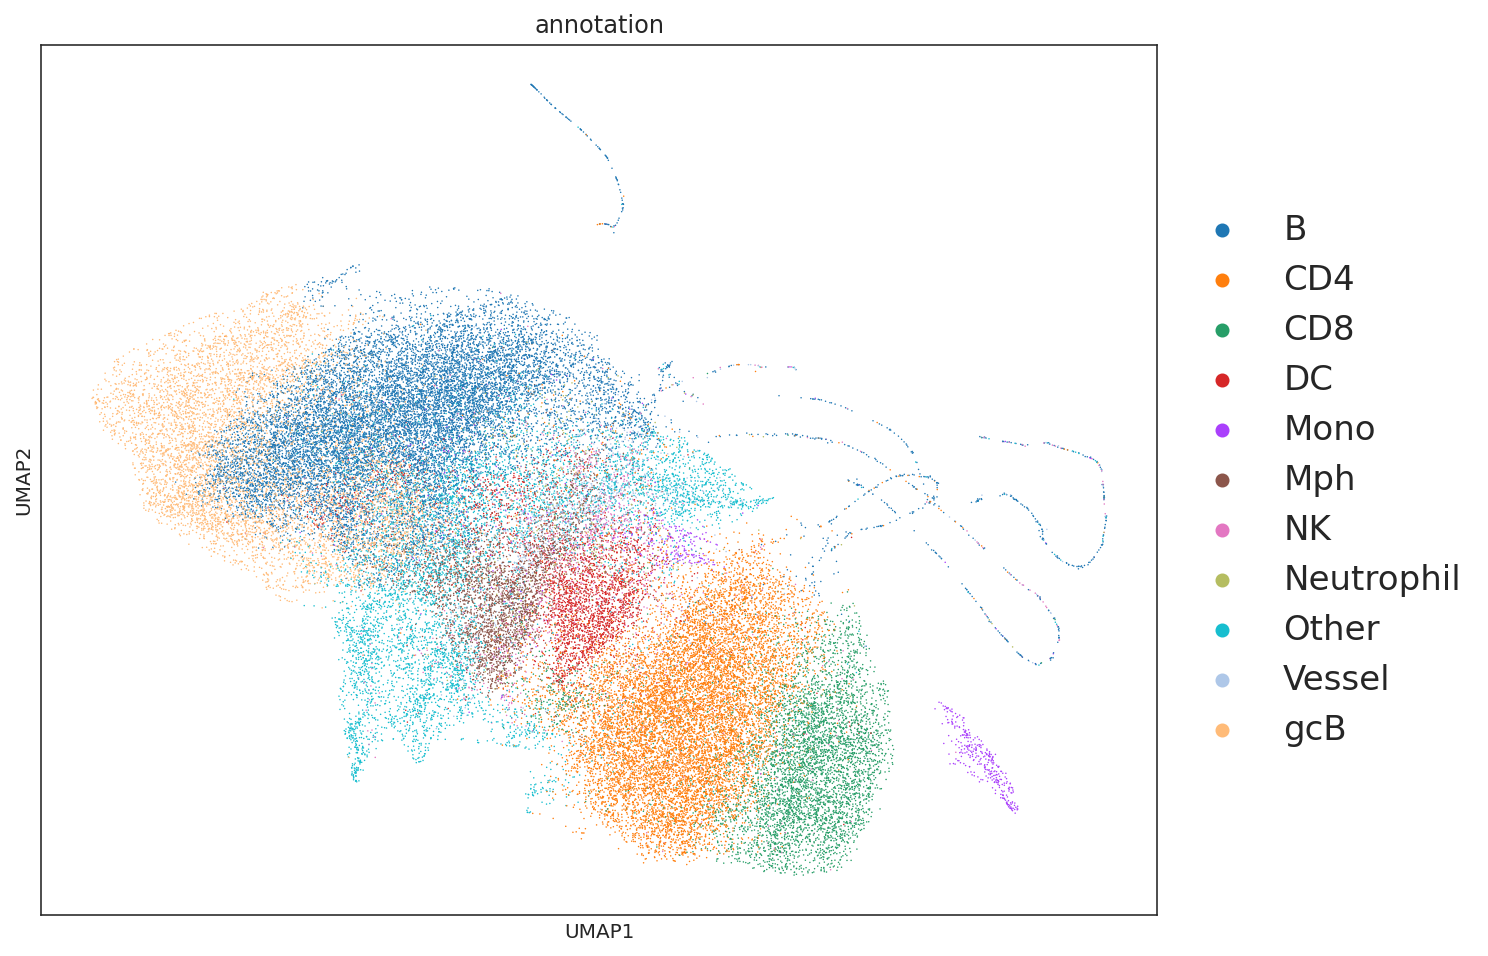

In [40]:
# full feature embeddings
feature_adata = ad.AnnData(latent_state_cat)
sc.pp.scale(feature_adata)
feature_adata.obs['annotation'] = list(df['cluster.termV2'])
sc.tl.pca(feature_adata, svd_solver='arpack')
# sc.pp.neighbors(feature_adata, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(feature_adata, n_neighbors=10)
sc.tl.umap(feature_adata)
plt.rcParams["figure.figsize"] = (10,8)
sc.pl.umap(feature_adata, color='annotation', legend_fontsize=17, show=False)

In [38]:
latent_state_cat.mean(axis = 0)

array([1.24942012, 1.03292861, 1.40500673, 1.62985869, 0.96953546,
       1.13148906, 1.0295823 , 1.322037  , 1.59669328, 0.88935773,
       0.48089705, 1.20765809, 0.63177482, 1.42109117, 1.36281158,
       1.02942492, 0.45263774, 0.61179102, 0.19954108, 0.61650572])

In [42]:
np.save(os.path.join(save_path, "spicemix_k20_minmax.npy"), latent_state_cat) 